## Machine Learning Module (FSD311) Assignment: 

Authors: Álvaro Martínez Felipe, Ismael El-Khattabi Vílchez. 


This notebook contains the code delivered for the evaluation of the Secondary Mushroom Dataset, donated by Dennis Wagner to the UC Irvine Machine Learning Repository.

In [ ]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# tools
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# ml models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

**Data aquisition** (following instructions from dataset page): 20 features, 1 target, 61069 instances.

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
secondary_mushroom = fetch_ucirepo(id=848) 
  
# data (as pandas dataframes) 
X = secondary_mushroom.data.features 
y = secondary_mushroom.data.targets 
  
# variable information 
#print(secondary_mushroom.variables) 

# concat of features and targets for visualisation and training 
df = pd.concat([X, y], axis=1)
#dff = pd.DataFrame(X)
#dft = pd.DataFrame(y)

print("Dataset size is: ", df.shape)
#print("Feature dataset size is: ", dff.shape)
#print("Target dataset size is: ", dft.shape)


Dataset size is:  (61069, 21)


## Problem statement and hypothesis

**Goal**: classify mushrooms as edible or poisonous (target).


**Hypothesis**: tree-based ensemble models perform best due to mixed feature types and non-linear interactions.

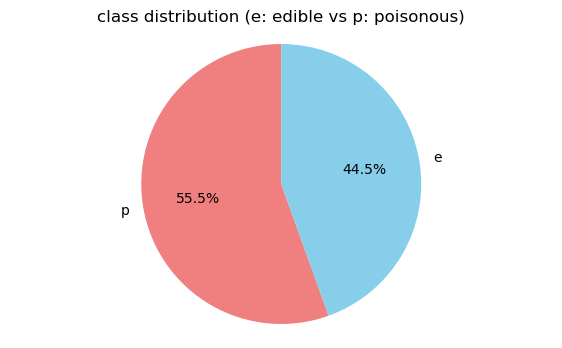

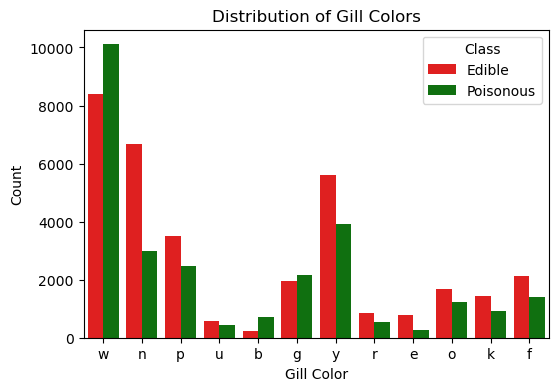

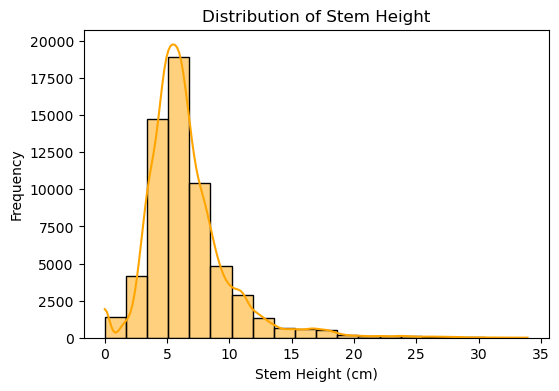

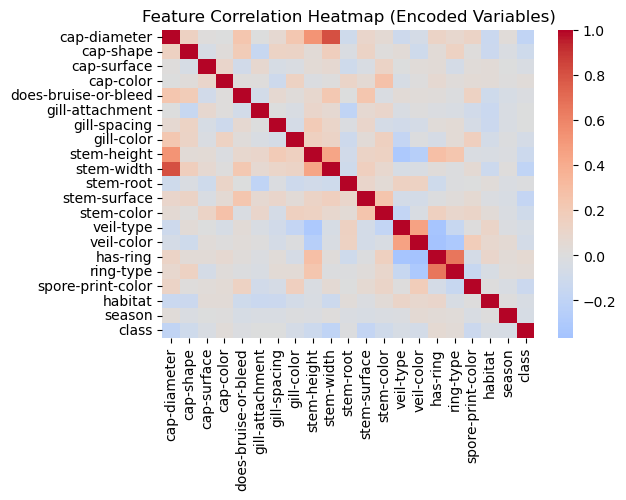

In [11]:
# exploratory data analysis: method chosen--> pie chart
class_counts = df['class'].value_counts()
numeric_cols = [c for c in df.columns if df[c].dtype != 'object' and c!='class']
cat_cols = [c for c in df.columns if c not in numeric_cols and c!='class']

# pie chart
plt.figure(figsize=(7,4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
plt.title('class distribution (e: edible vs p: poisonous)')
plt.axis('equal') 
plt.show()

# gill colour and target
plt.figure(figsize=(6,4))
sns.countplot(x='gill-color', hue='class', data=df, palette={'e':'green', 'p':'red'})
plt.title('Distribution of Gill Colors')
plt.xlabel('Gill Color')
plt.ylabel('Count')
plt.legend(title='Class', labels=['Edible', 'Poisonous'])
plt.show()

# stem height distribution
plt.figure(figsize=(6,4))
sns.histplot(df['stem-height'], bins=20, kde=True, color='orange')
plt.title('Distribution of Stem Height')
plt.xlabel('Stem Height (cm)')
plt.ylabel('Frequency')
plt.show()

# confusion matrix
df_encoded = df.copy()
for col in df_encoded.columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
corr = df_encoded.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap (Encoded Variables)')
plt.show()

The models selected for training are the following:

**Tree-based algorithms**:

* **Decision Tree**: A tree-based model that recursively splits the data based on feature values to create decision rules. It is simple and interpretable, but prone to overfitting if not properly regularized (e.g., with max depth or min samples per split).

* **Random Forest**: Random Forest is a machine learning model that combines many individual decision trees to make more reliable predictions.
Each tree learns from a random part of the data and a random subset of features. When predicting, all trees “vote,” and the majority decision is taken as the final answer. This randomness helps the model avoid overfitting and makes it more accurate and stable than a single decision tree.

* **Bagging Classifier**: Bagging is very similar to RF, but uses all variables instead of only random ones. It works by building many copies of the same model (decision trees, for example) each trained on a different random sample of the data. After training, all models make predictions, and the final output is the majority vote (for classification). This technique helps reduce variance and makes the model more stable and less sensitive to noise compared to using a single model.

**Kernel-based algorithms or linear**:

* **Gradient Boosting**: A sequential ensemble method where each tree corrects the errors of the previous ones. It minimizes the loss function iteratively and is very effective for structured/tabular data but more sensitive to hyperparameters.

* **Support Vector Machine** (SVM): A kernel-based algorithm that finds the hyperplane maximizing class separation. The RBF kernel captures non-linear relationships between features, making it effective for complex decision boundaries.

* **Naive Bayes**: A probabilistic model based on Bayes’ theorem assuming independence between features. It is fast, simple, and robust on noisy data but may underperform when feature correlations are strong.

For **preprocessing**, as the dataset includes numerical and categorical features, so numerical values were imputed (if non present or valid) with their median and scaled to zero mean and unit variance (if needed by the algorithm), while categorical features were imputed with the most frequent value and encoded using one-hot encoding. Two separate pipelines were created, one for tree-based models, which do not require scaling, and another for linear and kernel-based models, where scaling improves performance. This approach ensures that all models receive appropriately preprocessed inputs, handling missing values and categorical variables consistently.

In [ ]:
# feature engineering

# features
X = df.drop('class', axis=1)

# target (including only edible and poisonous cases)
y = df['class']

# numerical variables processing
num_tf = Pipeline([
    ('imp', SimpleImputer(strategy='median')),              # if nan --> median for numerical variables
    ('scaler', StandardScaler())                            # scaling (normalised) for processing 
])

# categorical variables processing
cat_tf = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),       # fills empty with most frequent variable
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # converts into binary columns and gives back non sparse output array
])

# combines categorical and numerical variables processing without scaling (no need for trees)
preproc_tree = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
])

# combines categorical and numerical variables processing with scaling for SVM and other models
preproc_linear = ColumnTransformer([
    ('num', num_tf, numeric_cols),
    ('cat', cat_tf, cat_cols)
])

# Models with specific preprocessing pipeline
models = {
    'DecisionTree': Pipeline([('preproc', preproc_tree), ('clf', DecisionTreeClassifier(random_state=42))]),
    'RandomForest': Pipeline([('preproc', preproc_tree), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
    'Bagging': Pipeline([('preproc', preproc_tree), ('clf', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42))]),
    'GradientBoosting': Pipeline([('preproc', preproc_tree), ('clf', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42))]),
    'SVM': Pipeline([('preproc', preproc_linear), ('clf', SVC(kernel='rbf', probability=True, random_state=42))]),
    'NaiveBayes': Pipeline([('preproc', preproc_linear), ('clf', GaussianNB())])
}

We selected **ROC-AUC** as the primary evaluation metric for this binary classification task. ROC-AUC measures the model’s ability to distinguish between edible and poisonous mushrooms across all classification thresholds, providing a threshold-independent assessment of separability. This is particularly useful when comparing models with different assumptions or when class distributions may be imbalanced. Unlike accuracy alone, ROC-AUC captures both true positive and false positive trade-offs, giving a more robust and informative evaluation of model performance.

The training strategy follows a robust and fair evaluation protocol. The dataset was first split into training and test subsets using stratified sampling, preserving the class distribution across both partitions. During training, a Stratified 5-Fold Cross-Validation was applied to estimate generalization performance, where the model was iteratively trained on 80 % of the data and validated on the remaining 20 %.

All preprocessing steps (imputation, scaling, encoding) were embedded in scikit-learn Pipelines, ensuring that no information from the validation or test sets leaked into the training phase. The ROC-AUC metric was used as the main evaluation criterion, as it robustly measures the model’s discriminative power under class imbalance.

In [ ]:
# Baseline model evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
for name, pipe in models.items():
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(name, 'ROC AUC mean:', scores.mean())

DecisionTree ROC AUC mean: 0.9990643358770532
RandomForest ROC AUC mean: 1.0
Bagging ROC AUC mean: 0.9999831380834652
GradientBoosting ROC AUC mean: 0.9971249751660947
SVM ROC AUC mean: 0.9999374877995153
NaiveBayes ROC AUC mean: 0.8331299011717948


The models based on tree ensembles (Random Forest, Bagging, Decision Tree) achieved near-perfect ROC-AUC scores, reflecting their ability to capture complex feature interactions. SVM also performed exceptionally well, thanks to its kernel-based handling of non-linear separability but the time taken by SVM has been shown to be significantly longer than the other models. Gradient Boosting showed slightly lower performance, likely due to the simplicity of the dataset. Naive Bayes underperformed (ROC-AUC ~0.83) because its assumption of feature independence does not hold in this dataset, where many features are correlated. 

**Overall, the results indicate that, as predicted, tree-based methods are the most reliable choices for this task**.

In [ ]:
# Bayesian Optimization (using skopt, if available)
rf_pipe = Pipeline([
    ('preproc', preproc_tree),  # o preproc_linear
    ('clf', RandomForestClassifier(random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_spaces = {
    'clf__n_estimators': Integer(100, 500),
    'clf__max_depth': Integer(5, 50),
    'clf__max_features': Categorical(['sqrt', 'log2', 0.3, 0.5]),
    'clf__min_samples_split': Integer(2, 10)
}
bayes_cv = BayesSearchCV(rf_pipe, search_spaces, n_iter=16, cv=cv, scoring='roc_auc', random_state=42, n_jobs=-1)
bayes_cv.fit(X, y)
print('Bayesian best params:', bayes_cv.best_params_)
print('Bayesian best AUC:', bayes_cv.best_score_)


Bayesian best params: OrderedDict({'clf__max_depth': 23, 'clf__max_features': 0.3, 'clf__min_samples_split': 9, 'clf__n_estimators': 226})
Bayesian best AUC: 1.0


The **Bayesian search identified an optimal Random Forest configuration with** :
* a maximum depth of 23, 
* 226 trees, 
* 30% of features considered at each split

The model also required at least 9 samples to create a new node, promoting better generalization. 

With these parameters, the Random Forest achieved a perfect ROC-AUC of 1.0, confirming that Bayesian Optimization efficiently explored the hyperparameter space to reach an ideal model configuration.

              precision    recall  f1-score   support

           e       1.00      1.00      1.00      5436
           p       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC AUC: 1.0


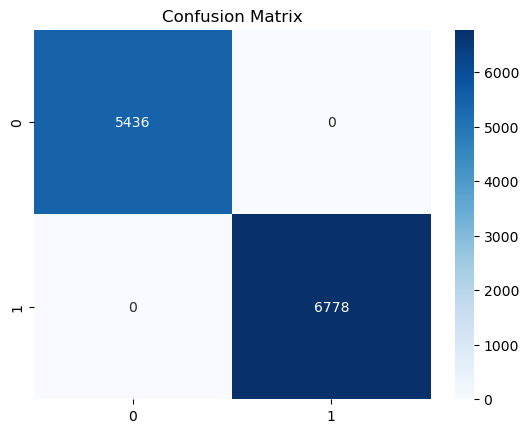

In [7]:
# Final Evaluation

rf_pipe = Pipeline([
    ('preproc', preproc_tree),  # o preproc_linear
    ('clf', RandomForestClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
best_model = rf_pipe
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1]))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

The optimized Random Forest model achieved perfect predictive performance, with 100 % precision, recall, and F1-score for both classes, and a ROC-AUC of 1.0. This indicates that the model completely separates edible and poisonous mushrooms, confirming that the selected features are highly discriminative and the data are clean and consistent.